# Evaluate water mass properties on the Amundsen Shelf using Pierre's observations

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')

from nemo_python_git.file_io import read_dutrieux
from nemo_python_git.utils import convert_to_teos10, distance_btw_points, closest_point
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.plots import circumpolar_plot, finished_plot

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test4_cont/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [3]:
def plot_land(nemo_mesh, file_var):
    lon_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

## Look at near-bottom T and S 

In [4]:
obs = read_dutrieux(eos='teos10')

# extract the bottom temperatures and salinities !!! Note that these are the deepest T, S in the dataset, not necessarily the bottom T, S
depth_bottom_obs = xr.where(obs['ConsTemp'].notnull(),-1*obs.coords['depth'],np.nan).max(dim='depth')
depth_bottom_obs = xr.where(depth_bottom_obs < 200, np.nan, depth_bottom_obs) # mask areas shallower than 200 m
bottom_Tobs      = xr.where(-1*obs.coords['depth']==depth_bottom_obs, obs['ConsTemp'], np.nan).mean(dim='depth')
bottom_Sobs      = xr.where(-1*obs.coords['depth']==depth_bottom_obs, obs['AbsSal'], np.nan).mean(dim='depth')

obs_bottom = xr.Dataset({'temp':bottom_Tobs, 'salt':bottom_Sobs, 'depth':depth_bottom_obs})

In [5]:
# load nemo grid for interpolation
nemo_ds_ref  = xr.open_dataset(f'{run_folder}eANT025.L121_1m_19790101_19791231_grid_T.nc') # load all the gridT files in the run folder
nemo_ds_ref  = nemo_ds_ref.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})

In [6]:
obs_interp = interp_latlon_cf(obs_bottom, nemo_ds_ref.isel(x=slice(450, 900), y=slice(130,350)), method='bilinear')

In [7]:
# load nemo simulations
gridT_files = glob.glob(f'{run_folder}/*grid_T*')
nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder

nemo_ds = nemo_ds.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})
    
# Average full time series:
nemo = nemo_ds.isel(time_counter=slice(180,None)).mean(dim='time_counter') # average (252, None) 2000-2016
# average (180, None) 1994-2016 (obs go to 2019)

In [8]:
nemo_mesh_ds = xr.open_dataset(nemo_mesh)
mesh_sub  = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

In [9]:
bathy = xr.where((mesh_sub.isfdraft > 0) | (mesh_sub.bathy_metry==0), np.nan, mesh_sub.bathy_metry)

In [247]:
# These indices are based on eANT025; eventually should generalize based on lat, lon
nemo_mesh_ds = xr.open_dataset(nemo_mesh)
mesh_sub     = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

fig, ax = plt.subplots(1,3, figsize=(20,12), subplot_axis.set_extent([-95, -135, -76, -68], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

img1 = ax[0].pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, 
                        bathy.values, transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.deep,vmin=0,vmax=4000)

img2 = ax[1].pcolormesh(depth_bottom_obs.lon.values, depth_bottom_obs.lat.values, 
                        depth_bottom_obs.values, transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.deep,vmin=0,vmax=4000)

img3 = ax[2].pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, 
                        (obs_interp.depth.values - bathy.values), 
                        transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.balance,vmin=-500,vmax=500)
ax[2].set_title('Observation depth minus model bathymetry depth')

lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)
for axis in ax.ravel():
    axis.set_extent([-95, -135, -76, -68], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    axis.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                    cmap=cl.ListedColormap(['DarkGrey']), zorder=3)

cax2 = fig.add_axes([0.91, 0.35, 0.02, 0.3])
cax3 = fig.add_axes([0.96, 0.35, 0.02, 0.3])
plt.colorbar(img2, cax=cax2, extend='both')
plt.colorbar(img3, cax=cax3, extend='both')

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2534751164.py, line 5)

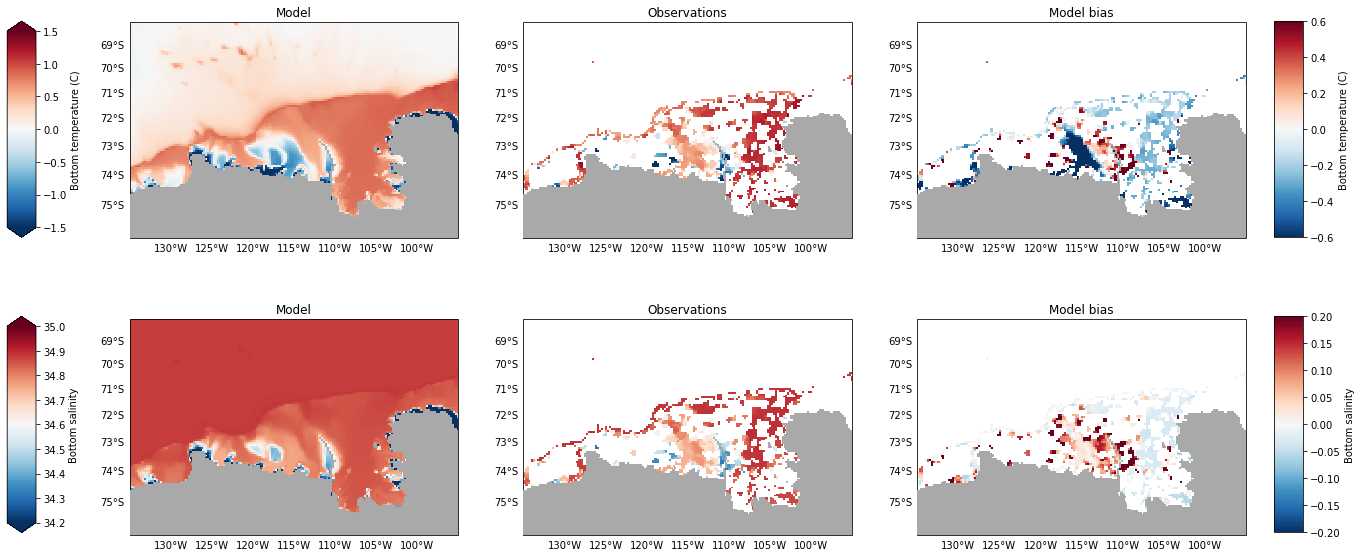

In [15]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average
nemo_plot = xr.Dataset({'temp':nemo['sbt'], 'salt':nemo['sbs']})
nemo_plot = nemo_plot.rename({'x_grid_T_inner':'x', 'y_grid_T_inner':'y'}).isel(x=slice(450, 900), y=slice(130,350))
# Apply NEMO land mask to both
nemo_plot = nemo_plot.where(nemo_plot['temp']!=0)
obs_plot  = obs_interp.where(nemo_plot['temp'].notnull()*obs_interp.notnull())
obs_plot  = obs_plot.where(nemo_plot['temp']!=0)
nemo_plot = nemo_plot.where(nemo_plot['temp']!=0)
# Get difference from obs
obs_plot = xr.where(np.abs((obs_interp.depth.values - bathy.values)) > 200, np.nan, obs_plot)
bias_plot = nemo_plot - obs_plot
    
# These indices are based on eANT025cax=caxbase_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test4_cont/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc', ; eventually should generalize based on lat, lon
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)
# Little helper function to help cartopy with landmasking
def mask_land(nemo_mesh, file_var):
    lon_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, mesh_sub.nav_lon.values)
    lat_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, mesh_sub.nav_lat.values)
    plot_var = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, file_var.values)
    return lon_plot, lat_plot, plot_var 
      
data_plot  = [nemo_plot, obs_plot, bias_plot]
var_titles = ['Bottom temperature (C)', 'Bottom salinity']
vmin = [-1.5, -1.5, -0.6, 34.2, 34.2, -0.2]
vmax = [1.5, 1.5, 0.6, 35, 35, 0.2]

#------------- Plot figure -----------------
fig, ax = plt.subplots(2,3, figsize=(20,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

for axis in ax.ravel():
    axis.set_extent([-95, -135, -76, -68], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

i=0nemo_TS_sub.so.values, nemo_TS_sub.thetao.values
for v, var in enumerate(['temp', 'salt']):
    for n, name in enumerate(['Model', 'Observations', 'Model bias']):
        lon_plt, lat_plt, var_plt = mask_land(mesh_sub, data_plot[n][var])
        img = ax[v,n].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap='RdBu_r', vmin=vmin[i], vmax=vmax[i])
        ax[v,n].pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                           cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
        ax[v,n].set_title(name)
        i+=1
        if n != 1:
            cax = fig.add_axes([0.04+0.44*n, 0.56-0.41*v, 0.02, 0.3])
            plt.colorbar(img, cax=cax, extend='both' if n==0 else 'neither', label=var_titles[v])

!!! Need some more observations in the Getz region to evaluate the bias there

### Look at transect coming off the shelf


In [10]:
fileT='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/pierre-dutrieux/ASEctd_griddedMean_PT.nc'
fileS='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/pierre-dutrieux/ASEctd_griddedMean_S.nc'
obs  = xr.open_mfdataset([fileT, fileS])

In [37]:
x= [0,10,25,30,47,50,82,92,115,175,200,220]
y = [38,40,45,50,55,61,58,72,80,85,100,95]
print(obs.latgrid.isel(indexlon=xr.DataArray(x, dims='n'), indexlat=xr.DataArray(y, dims='n')).values)
print(obs.longrid.isel(indexlon=xr.DataArray(x, dims='n'), indexlat=xr.DataArray(y, dims='n')).values)

[-73.72 -73.6  -73.3  -73.   -72.7  -72.34 -72.52 -71.68 -71.2  -70.9
 -70.   -70.3 ]
[-137.  -135.  -132.  -131.  -127.6 -127.  -120.6 -118.6 -114.  -102.
  -97.   -93. ]


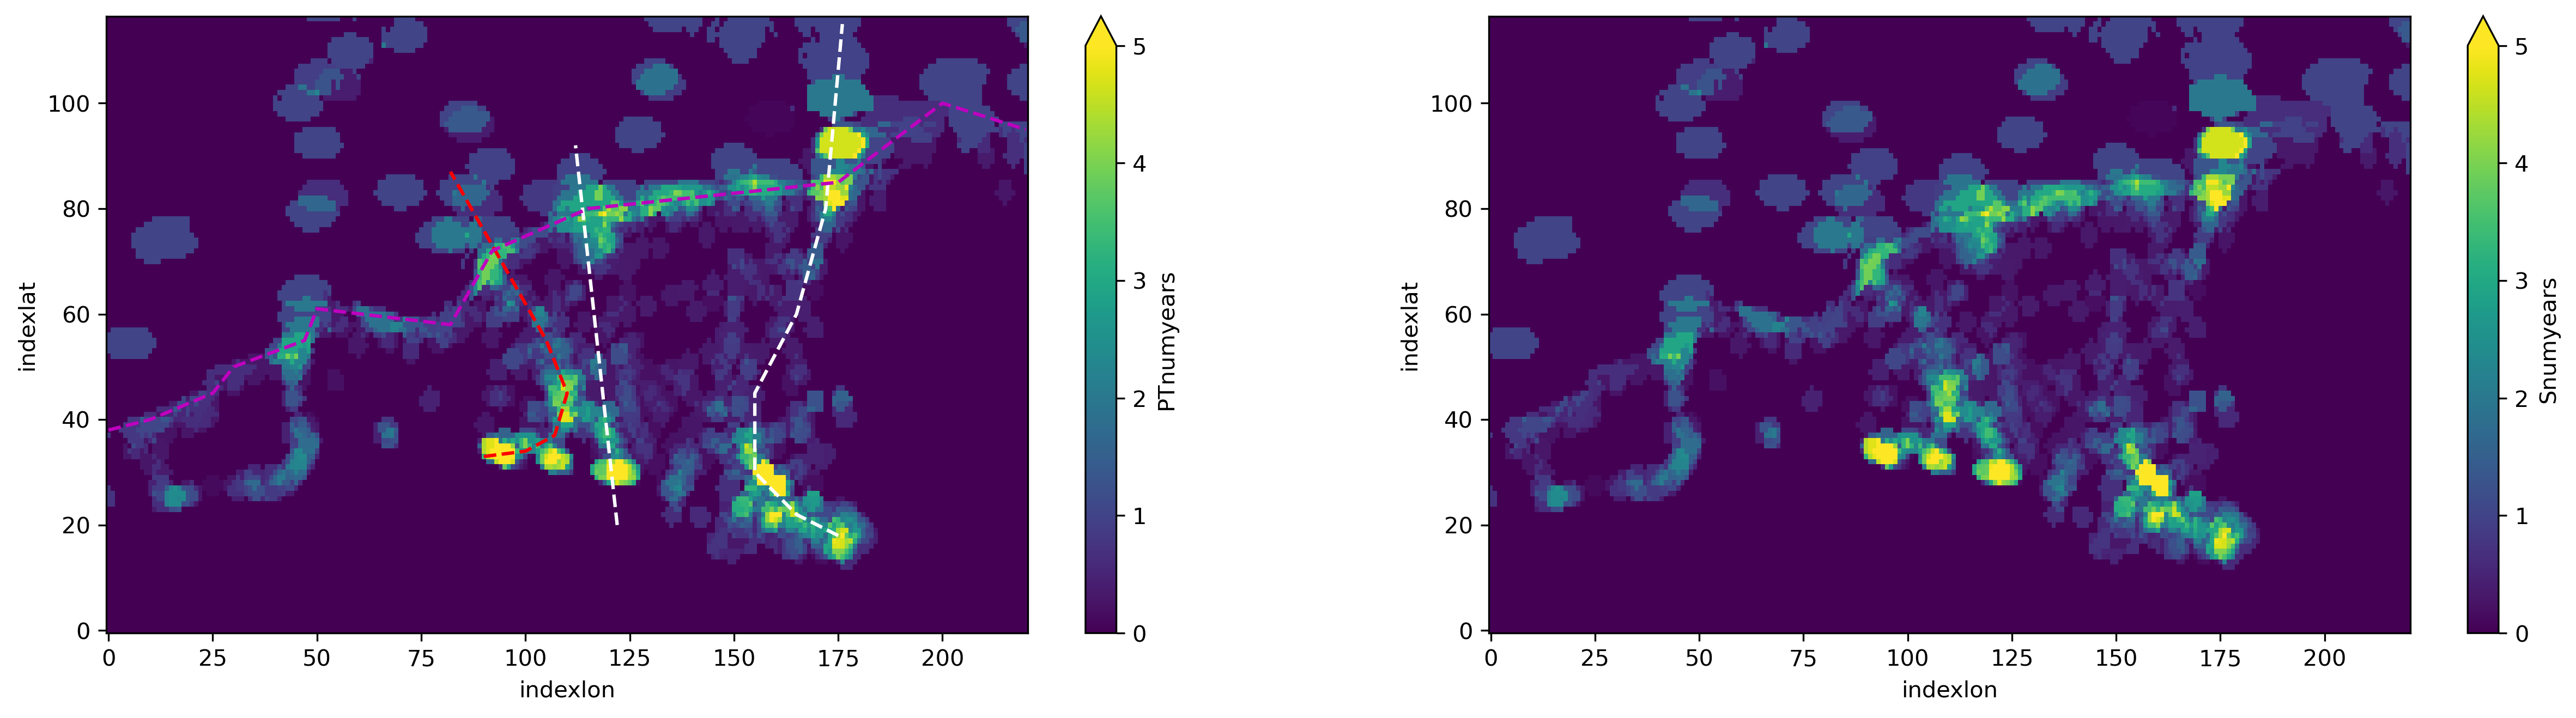

In [33]:
fig, ax = plt.subplots(1,2, figsize=(20,5),dpi=300)
obs.PTnumyears.mean(dim='indexdepth').plot(vmin=0, vmax=5, ax=ax[0])
obs.Snumyears.mean(dim='indexdepth').plot(vmin=0, vmax=5, ax=ax[1])
ax[0].plot([90,100,107,110,105,82],[33,34,37,45,55,87],'--r')
ax[0].plot([122,112],[20,92],'--w')
ax[0].plot([175,165,155,155,165,172,176],[18,22,30,45,60,80,115],'--w')

ax[0].plot([0,10,25,30,47,50,82,92,115,175,200,220],[38,40,45,50,55,61,58,72,80,85,100,95],'--m')

So, draw a transect from a bit west of Bear Ridge off the shelf and from Thwaites off the shelf. 

In [33]:
from nemo_python_git.constants import transect_amundsen

In [26]:
# Function finds x, y coordinates associated with the specified transect longitude and latitudes
# Inputs:
# data      : xarray dataset to calculate transect for
# waypoints : list of array of longitudes and array of latitudes that are waypoints identifying the route of a transect, 
#             so the transect consists of lines connecting these coordinates
# opt_float : boolean option whether you want to get an array of coordinates as integers (floored) or floats
# Outputs: vector_x, vector_y are coordinates of the dataset that lie along the specified transect route
def transect_coords_from_latlon_waypoints(data, waypoints, opt_float=True):

    # find the indices associated with the specified corner longitude and latitudes
    transect_data_coord = [closest_point(data, (waypoints[0][i],waypoints[1][i])) for i in range(0,len(waypoints[0]))]
    yind = list(zip(*transect_data_coord))[0]
    xind = list(zip(*transect_data_coord))[1]

    # now, connect the x, y turning points to create a transect connecting these coordinates
    vector_x = np.array([]); vector_y = np.array([]);
    for i in range(0,len(xind)-1):
        vec_x, vec_y = connect_coord_points((xind[i], yind[i]),(xind[i+1], yind[i+1]), opt_float=opt_float)
        vector_x = np.append(vector_x, vec_x)
        vector_y = np.append(vector_y, vec_y)

    if opt_float:
        return vector_x, vector_y
    else:
        return vector_x.astype(int), vector_y.astype(int)

In [27]:
# Function takes two grid points in coordinates and finds the coordinates of the points connecting a line between pt0 and pt1 
# Inputs:
# pt0, pt1  : tuples of x and y coordinates
# opt_float : (optional) boolean whether to draw a smooth line connecting the points (so with decimals) or floored to integer steps
def connect_coord_points(pt0, pt1, opt_float=True):
    
    dx = pt1[0] - pt0[0]
    dy = pt1[1] - pt0[1]

    # increment the axis with the most steps by steps of 1, then estimate the coordinates of the other vector
    if np.abs(dy) > np.abs(dx):
        vec_y = np.arange(pt0[1], pt1[1] + np.sign(dy), np.sign(dy))
        if opt_float:
            vec_x = np.linspace(pt0[0], pt1[0], len(vec_y))
        else:
            vec_x = np.floor(np.linspace(pt0[0], pt1[0], len(vec_y)))
    else:
        vec_x = np.arange(pt0[0], pt1[0] + np.sign(dx), np.sign(dx))
        if opt_float:
            vec_y = np.linspace(pt0[1], pt1[1], len(vec_x))
        else:
            vec_y = np.floor(np.linspace(pt0[1], pt1[1], len(vec_x)))
    
    return vec_x, vec_y

In [28]:
# Function calculates distances (km) from each point in a transect to the first point based on lats and lons
def distance_along_transect(data_transect):

    # calculate distance from each point in the transect to the first point in the transect:
    transect_distance = np.array([distance_btw_points((data_transect.nav_lon.values[0], data_transect.nav_lat.values[0]),
                                                      (data_transect.nav_lon.values[i+1], data_transect.nav_lat.values[i+1])) for i in range(0, data_transect.n.size-1)])
    # prepend 0 for the first distance point
    transect_distance = np.insert(transect_distance, 0, 0) 
    # convert from meters to km
    transect_distance = transect_distance/1000
    
    return transect_distance

In [29]:
# Function plots a transect of a variable
# Inputs:
# ax            : axis to plot the transect on
# distance_vec  : array of distance points along transect (could also be some other x-axis like lons or lats)
# data_transect : xarray dataset containing the depth and variable of the dataset to visualize
# var_name      : string name of variable to visualize
# ylim          : (optional) vertical axis range (as tuple)
# label         : (optional) string of name of colorbar label, otherwise defaults to the units of the variable
def plot_transect(ax, distance_vec, data_transect, var_name, ylim=(1600, -20), vmin=33, vmax=34.8, cmap=cmocean.cm.haline, label=None):
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel('Depth (m)')

    distance, depth = np.meshgrid(distance_vec, np.abs(data_transect.depth))
    kwags = {'vmin':vmin, 'vmax':vmax, 'cmap':cmap}
    cm1 = ax.pcolormesh(distance.transpose(), depth.transpose(), data_transect[var_name].values, **kwags)

    if label:
        plt.colorbar(cm1, ax=ax, extend='both', label=label)
    else:
        plt.colorbar(cm1, ax=ax, extend='both', label=data_transect[var_name].unit)
    
    return

In [30]:
def plot_evaluate_transect(obs_distance, obs_transect, sim_distance, sim_transect, savefig=False, fig_name=''):

    # in the future, add a panel that shows the bias comparison (need to use the interpolated observations for that)

    fig, ax = plt.subplots(2,1, figsize=(8,6), dpi=300)

    plot_transect(ax[0], obs_distance, obs_transect, 'PTmean', vmin=-2, vmax=1, cmap=cmocean.cm.dense, label='Potential Temp.')
    plot_transect(ax[1], sim_distance, sim_transect, 'thetao', vmin=-2, vmax=1, cmap=cmocean.cm.dense, label='Conservative Temp.') 

    # bias: obs need to be interpolated in x,y and also in depth
    # sim_distance, sim_transect.rename({'deptht':'depth'}) - obs_interp_transect.rename({'depthvec':'depth'})
    
    ax[1].set_xlabel('Distance (km)')

    if savefig:
        finished_plot(fig, fig_name=fig_name)

    return

In [67]:
# Function produces figures of transects of observations on the Amundsen Sea shelf and simulation results
# Inputs:
# run_folder : string path to folder containing NEMO simulations (gridT files)
# savefig    : (optional) boolean whether to save figure within figures sub-directory in run_folder
def evaluate_Amundsen_transects(run_folder, savefig=False):
    # load nemo simulations
    gridT_files  = glob.glob(f'{run_folder}/*grid_T*')
    nemo_ds      = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder
    nemo_ds      = nemo_ds.rename({'x_grid_T':'x', 'y_grid_T':'y', 'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 'deptht':'depth'}) 
    ## note that the depth should have partial steps varying spatially, so need to fix
    nemo_results = nemo_ds.isel(time_counter=slice(180,None)).mean(dim='time_counter')  # Average time series
    
    # load observations:
    fileT='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/pierre-dutrieux/ASEctd_griddedMean_PT.nc'
    fileS='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/pierre-dutrieux/ASEctd_griddedMean_S.nc'
    obs  = xr.open_mfdataset([fileT, fileS])
    
    dutrieux_obs = obs.rename({'longrid':'nav_lon','latgrid':'nav_lat','depthvec':'depth'}).rename_dims({'indexlat':'y', 'indexlon':'x'})
    
    # calculate transects and plot:
    for transect in ['shelf_west']: #, 'shelf_mid', 'shelf_east']:
        # get coordinates for the transect:
        x_obs, y_obs = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen[transect], opt_float=False)
        x_sim, y_sim = transect_coords_from_latlon_waypoints(nemo_results, transect_amundsen[transect], opt_float=False)

        # subset the datasets to the coordinates of the transect:
        obs_transect = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))
        sim_transect = nemo_results.isel(x=xr.DataArray(x_sim, dims='n'), y=xr.DataArray(y_sim, dims='n'))

        # calculate the distance of each point along the transect relative to the start of the transect:
        obs_distance = distance_along_transect(obs_transect)
        sim_distance = distance_along_transect(sim_transect)

        # visualize the transect:
        # plot_evaluate_transect(obs_distance, obs_transect, sim_distance, sim_transect, 
                               # savefig=True, fig_name=f'{run_folder}figures/evaluation_transect_{transect}.jpg')

    return obs_distance, obs_transect, sim_distance, sim_transect

In [54]:
## to do: for transects
# - mask land in transect plots
# - mask ice shelf in a different color (land_color, iceshelf_color)
# - fix the depths that are read in for the transect from NEMO to include partial steps

In [68]:
run_folder = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test4_cont/'
obs_distance, obs_transect, sim_distance, sim_transect = evaluate_Amundsen_transects(run_folder)

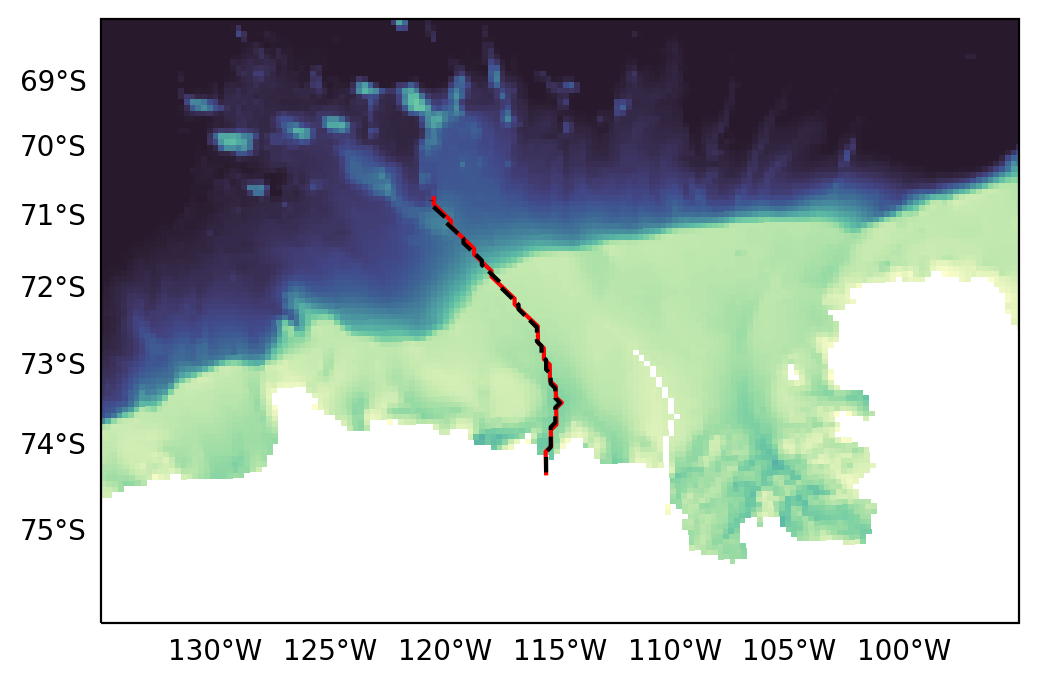

In [69]:
# now do the same for a transect in the simulation

nemo_mesh_ds = xr.open_dataset(nemo_mesh)
mesh_sub     = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

fig, ax = plt.subplots(1,1, figsize=(6,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=200)

img1 = ax.pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, 
                     bathy.values, transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.deep,vmin=0,vmax=4000)

ax.plot(sim_transect.nav_lon.values, sim_transect.nav_lat.values, '-r', transform=ccrs.PlateCarree())
ax.plot(obs_transect.nav_lon.values, obs_transect.nav_lat.values, '--k', transform=ccrs.PlateCarree())
# ax.plot(sim_transect.nav_lon.values, sim_transect.nav_lat.values, '--r', transform=ccrs.PlateCarree())
# ax.plot(sim_transect.nav_lon.values, sim_transect.nav_lat.values, '--r', transform=ccrs.PlateCarree())

ax.set_extent([-95, -135, -76, -68], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

In [215]:
def plot_loc_transects(obs, obs_transect1, obs_transect2, obs_transect3, var_name, 
                       depth_slice=slice(0,10), vmin=32, vmax=34, cmap=cmocean.cm.haline):

    # setup map
    fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=300)
    ax.set_extent([-95, -135, -76, -69], ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

    # plot background obs
    img1 = ax.pcolormesh(obs.longrid.values, obs.latgrid.values, obs[var_name].isel(indexdepth=depth_slice).mean(dim='indexdepth').values, 
                         transform=ccrs.PlateCarree(),rasterized=True,cmap=cmap,vmin=vmin,vmax=vmax, zorder=1)    
    # mask land
    nemo_mesh_ds = xr.open_dataset(nemo_mesh)
    mesh_sub     = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)
    lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)
    ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                  cmap=cl.ListedColormap(['DarkGrey']), zorder=2)

    # draw lines for transect locations
    ax.plot(obs_transect1.longrid.values, obs_transect1.latgrid.values, '--k', transform=ccrs.PlateCarree(), zorder=3)
    ax.plot(obs_transect2.longrid.values, obs_transect2.latgrid.values, '--k', transform=ccrs.PlateCarree(), zorder=3)
    ax.plot(obs_transect3.longrid.values, obs_transect3.latgrid.values, '--k', transform=ccrs.PlateCarree(), zorder=3)
    
    cax1 = fig.add_axes([0.91, 0.35, 0.02, 0.3])
    plt.colorbar(img1, cax=cax1, extend='both')
    return

In [80]:
def plot_obs_transect(ax, distance_vec, obs_transect, var_name, vmin=33, vmax=34.8, cmap=cmocean.cm.haline, label=None):
    ax.set_ylim(-1600, 20)
    ax.set_ylabel('Depth (m)')

    distance, depth = np.meshgrid(distance_vec, obs_transect.depthvec)
    kwags = {'vmin':vmin, 'vmax':vmax, 'cmap':cmap}
    cm1 = ax.pcolormesh(distance.transpose(), depth.transpose(), obs_transect[var_name].values, **kwags)

    if label:
        plt.colorbar(cm1, ax=ax, extend='both', label=label)
    else:
        plt.colorbar(cm1, ax=ax, extend='both', label=obs_transect[var_name].unit)
    
    return

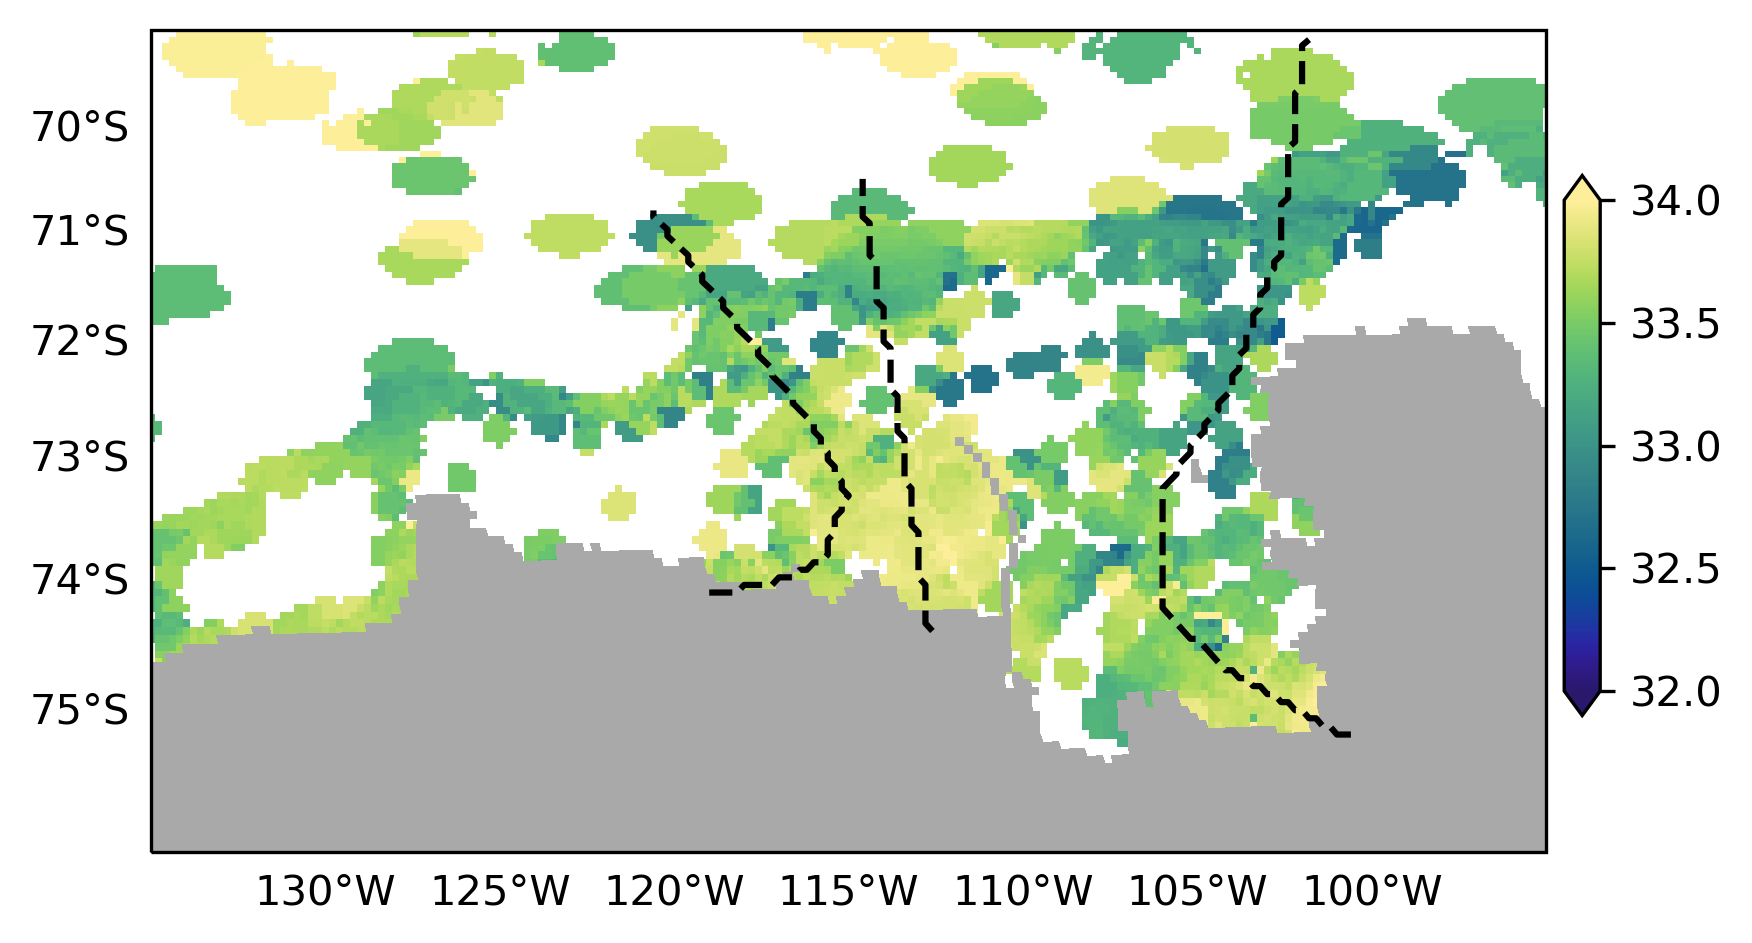

In [219]:
plot_loc_transects(obs, obs_transect1, obs_transect2, obs_transect3, 'Smean', cmap=cmocean.cm.haline)

/tmp/ipykernel_527/528912121.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm1 = ax.pcolormesh(distance.transpose(), depth.transpose(), obs_transect[var_name].values, **kwags)


Text(0.5, 0, 'Distance (km)')

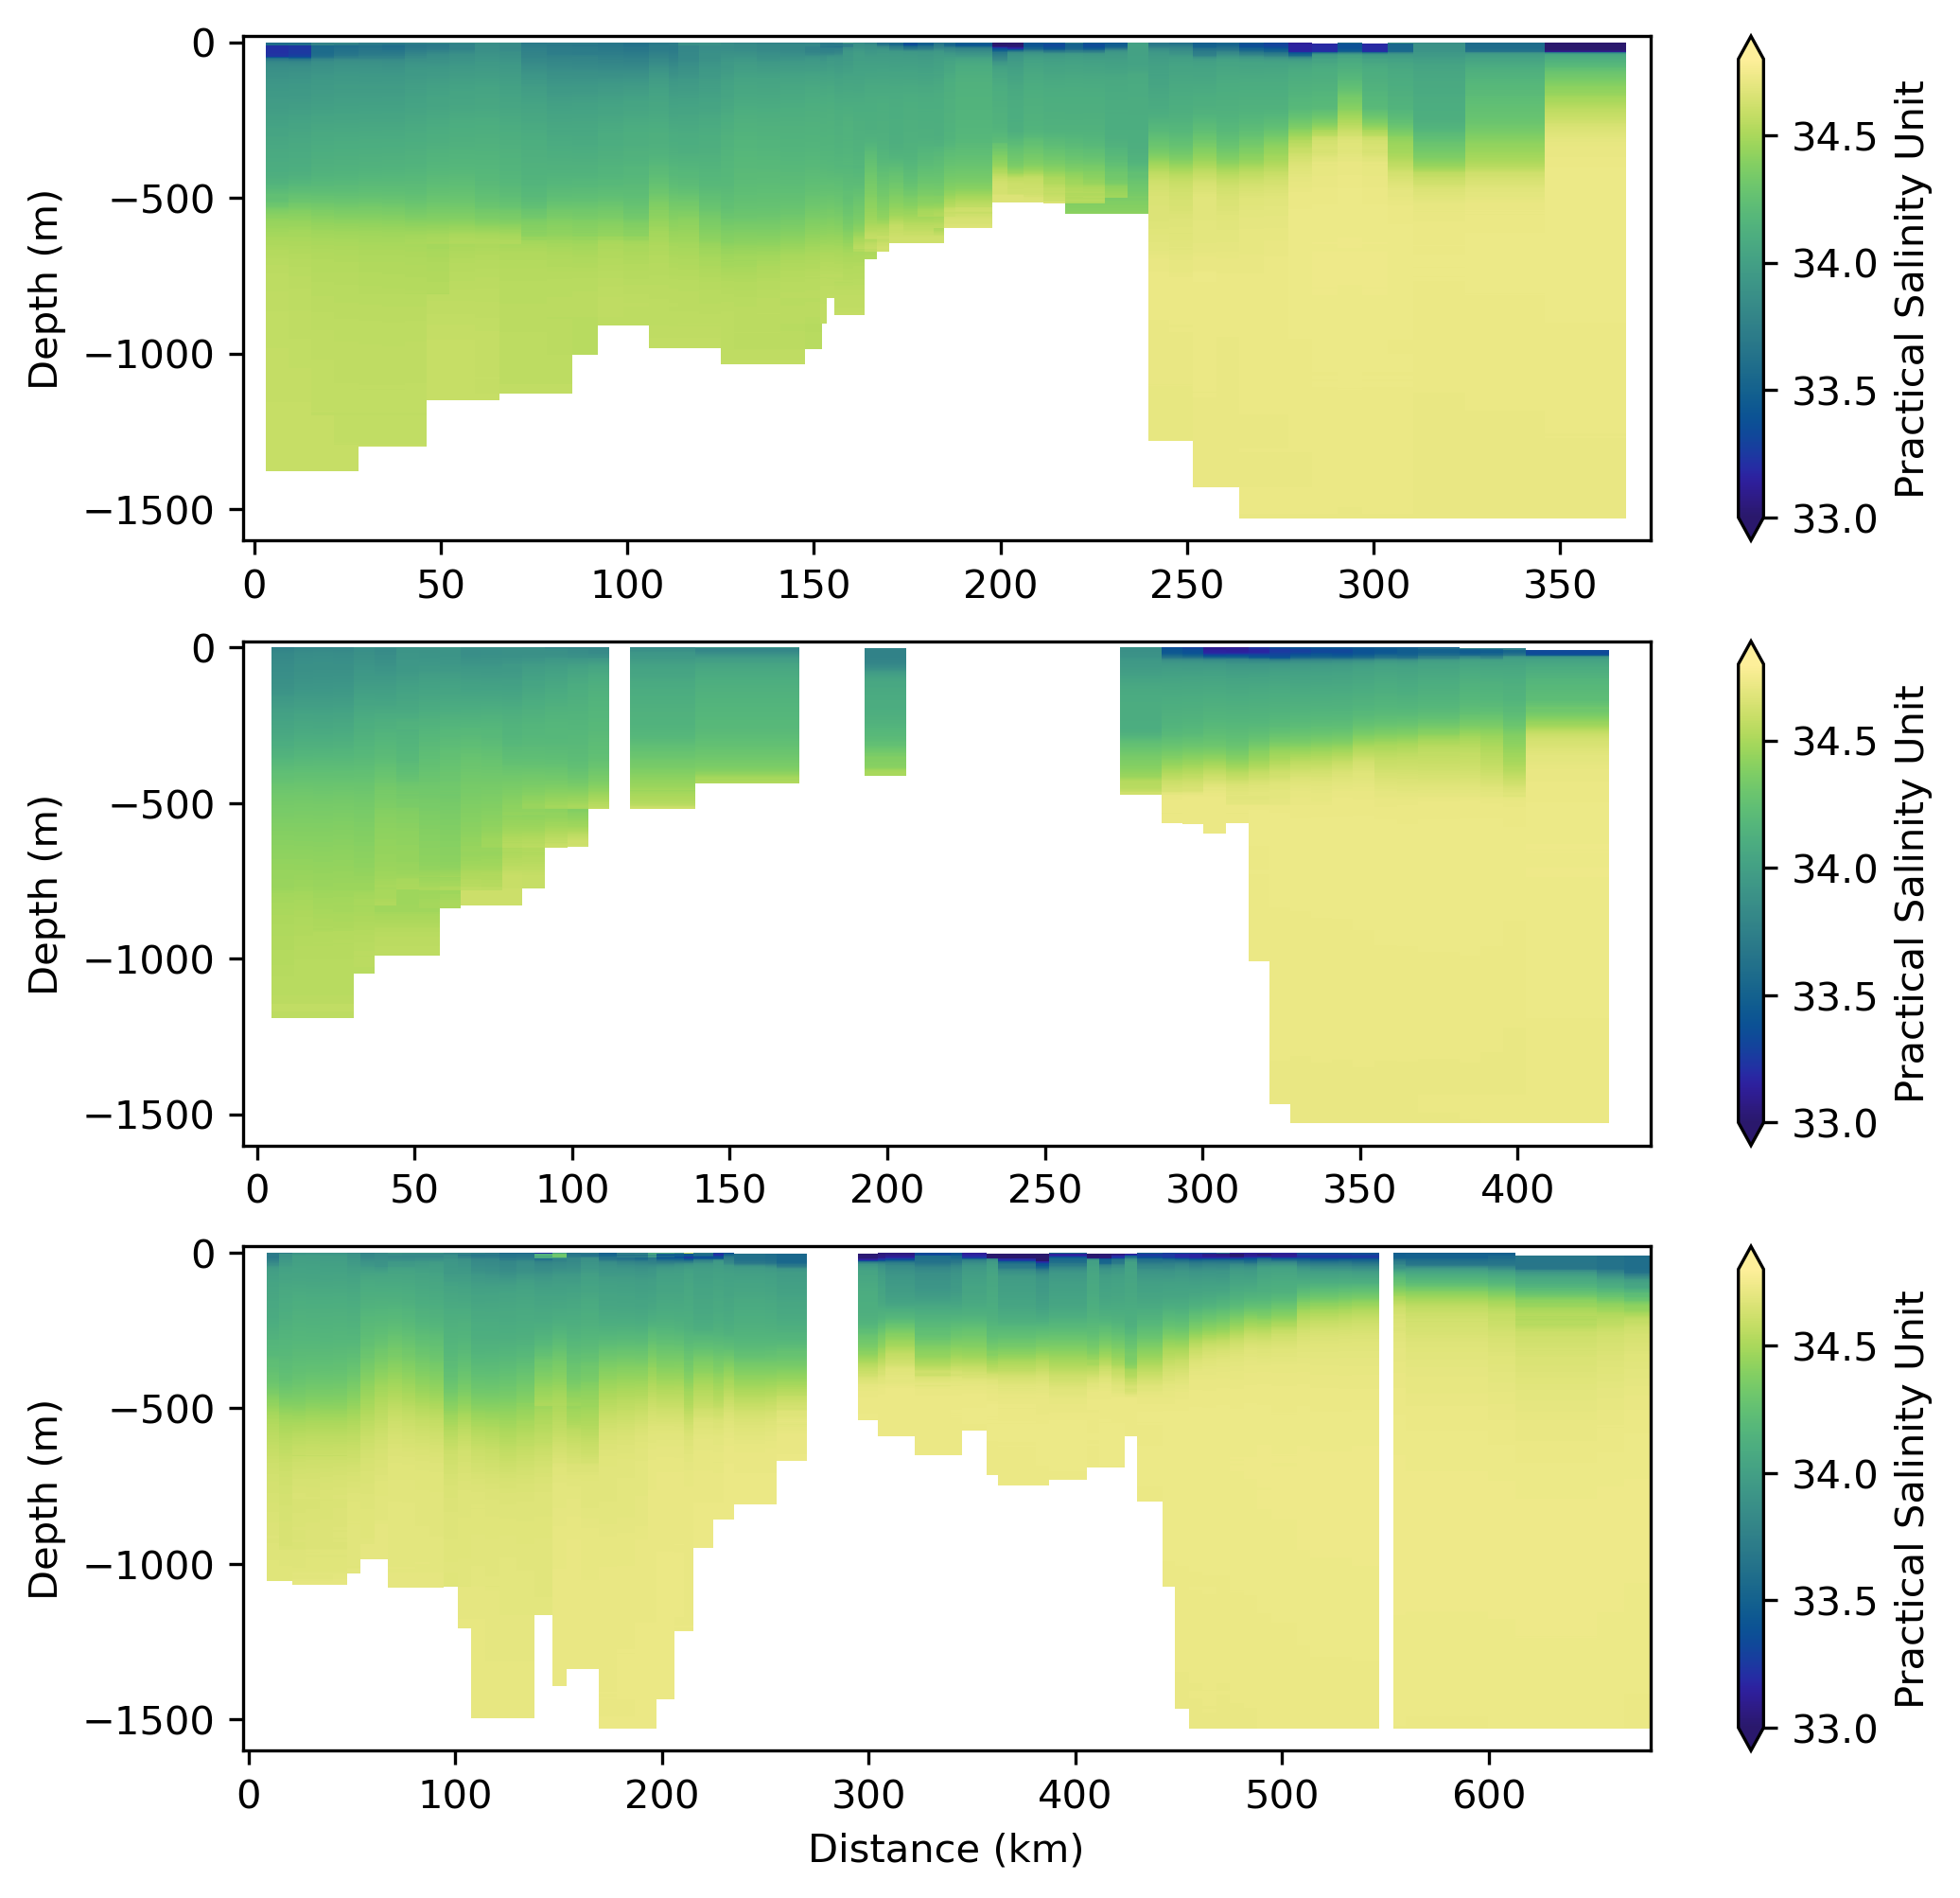

In [204]:
fig, ax = plt.subplots(3,1, figsize=(8,8), dpi=300)

plot_obs_transect(ax[0], d1, obs_transect1, 'Smean')
plot_obs_transect(ax[1], d2, obs_transect2, 'Smean')
plot_obs_transect(ax[2], d3, obs_transect3, 'Smean')

ax[2].set_xlabel('Distance (km)')

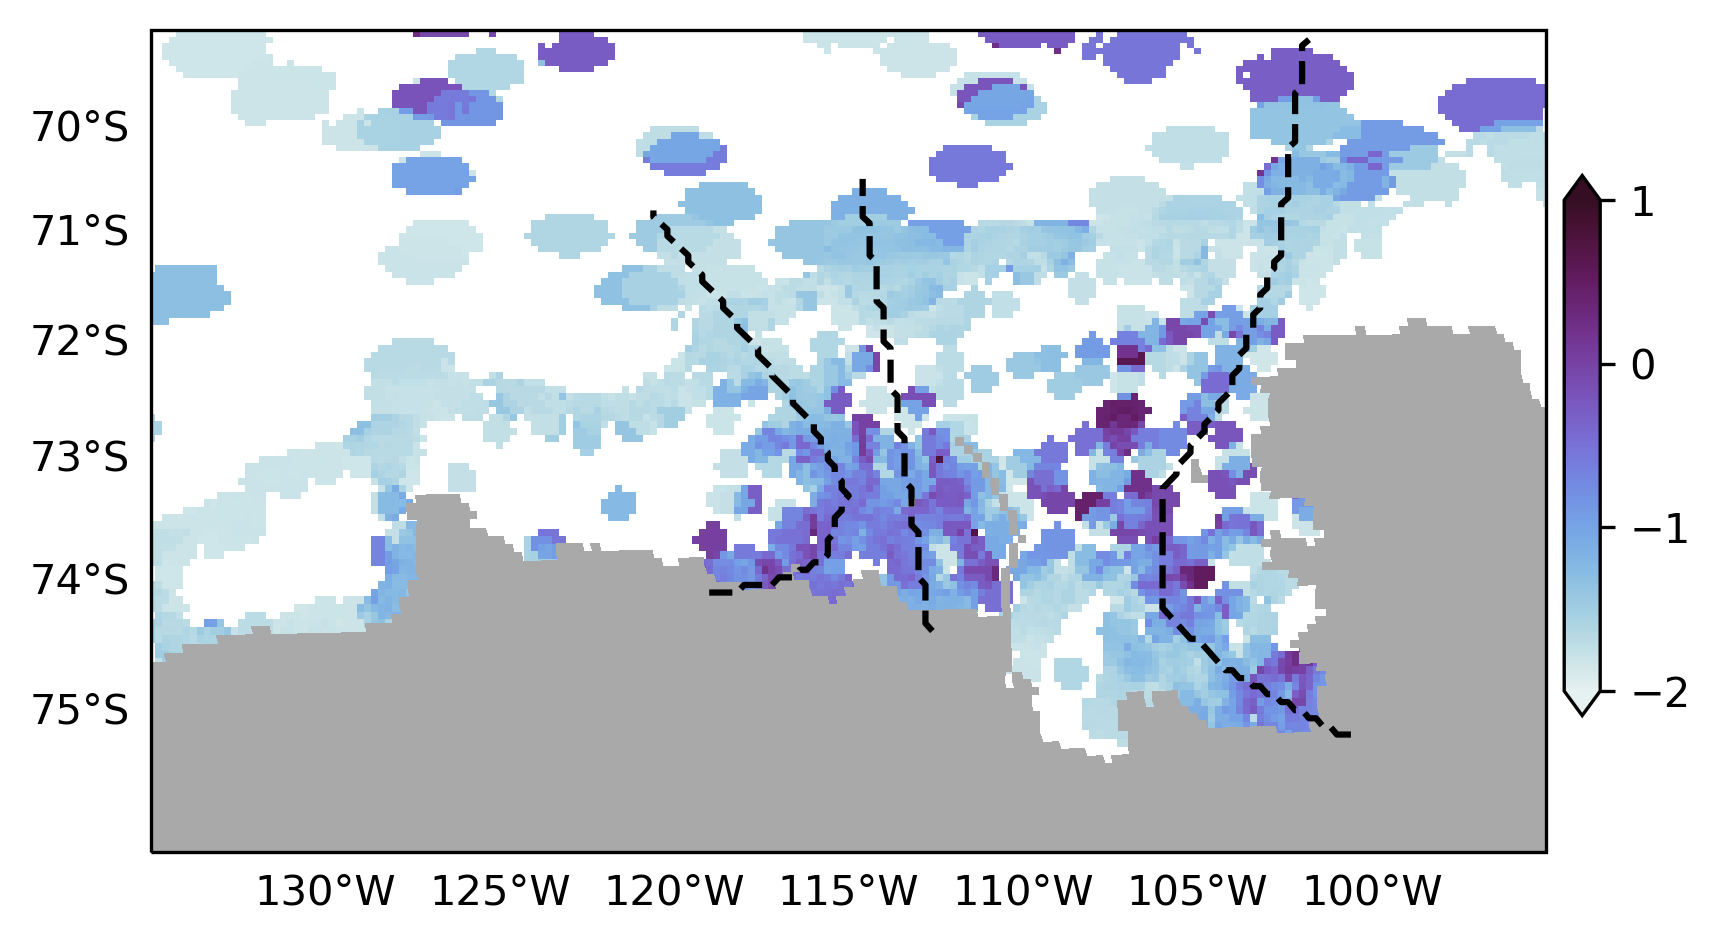

In [220]:
plot_loc_transects(obs, obs_transect1, obs_transect2, obs_transect3, 'PTmean', cmap=cmocean.cm.dense, vmin=-2, vmax=1)

/tmp/ipykernel_527/244162450.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm1 = ax.pcolormesh(distance.transpose(), depth.transpose(), obs_transect[var_name].values, **kwags)


Text(0.5, 0, 'Distance (km)')

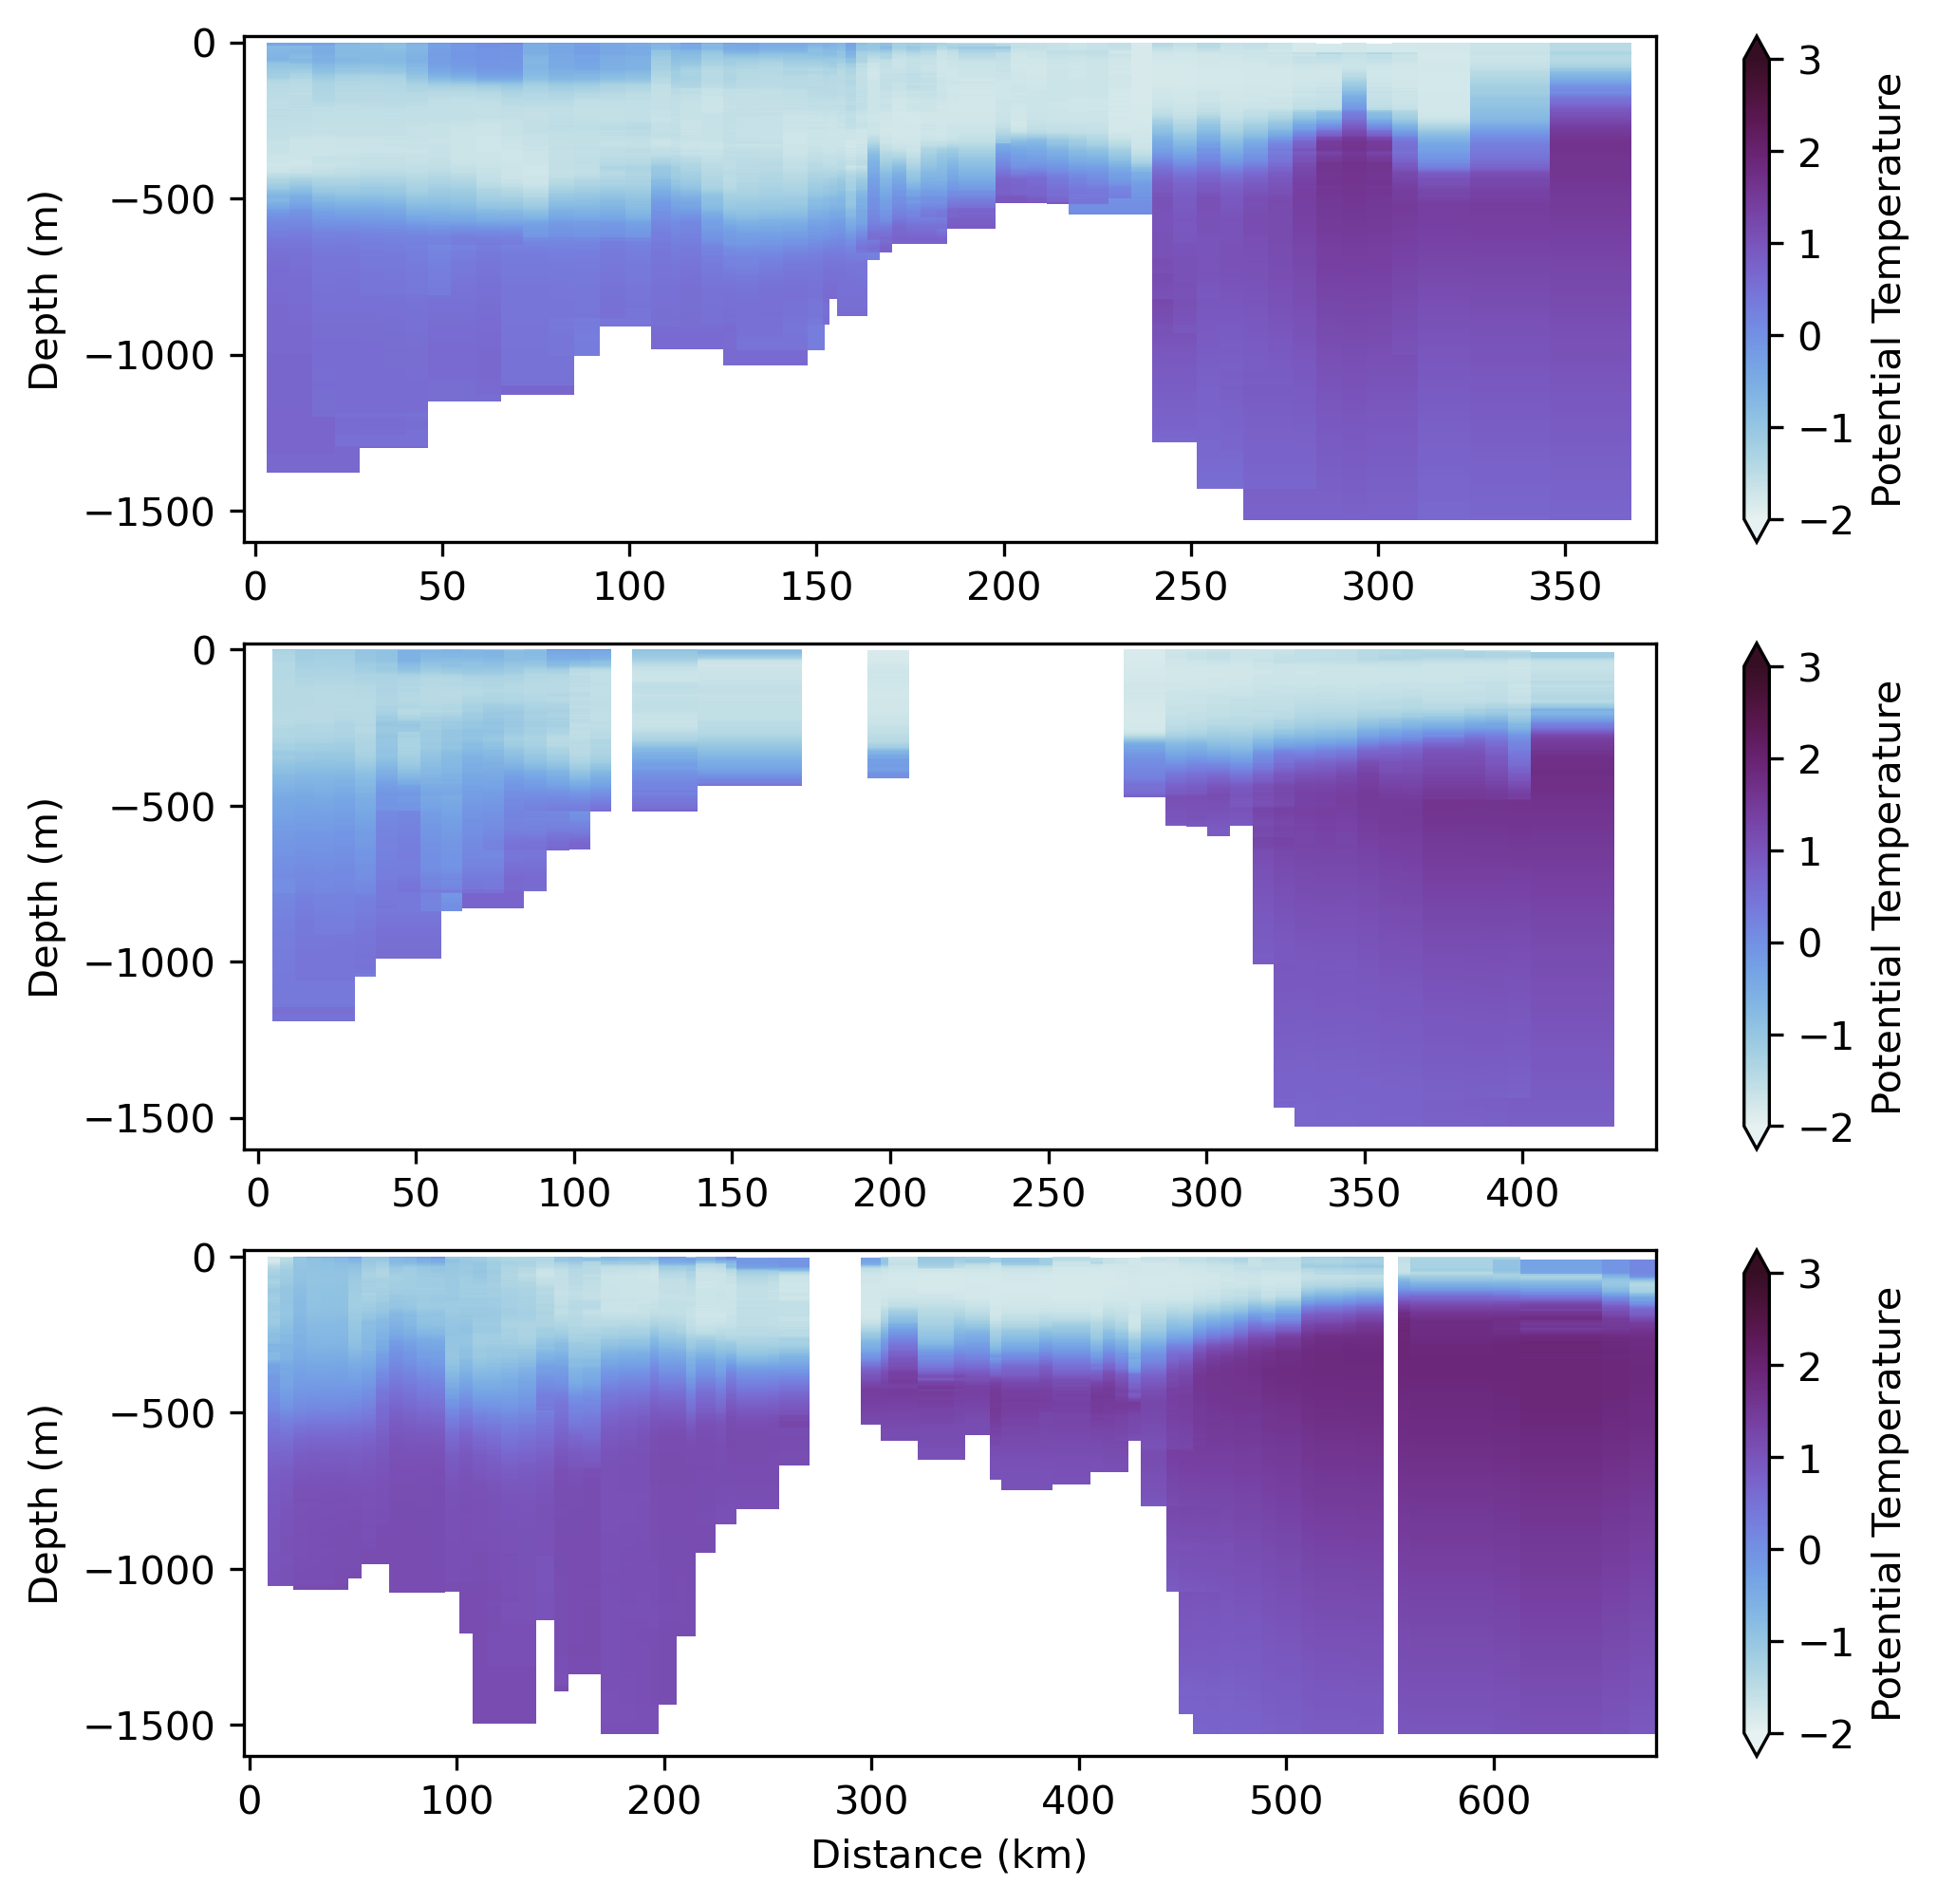

In [208]:
fig, ax = plt.subplots(3,1, figsize=(8,8), dpi=300)

plot_obs_transect(ax[0], d1, obs_transect1, 'PTmean', cmap=cmocean.cm.dense, vmin=-2, vmax=3, label='Potential Temperature')
plot_obs_transect(ax[1], d2, obs_transect2, 'PTmean', cmap=cmocean.cm.dense, vmin=-2, vmax=3, label='Potential Temperature')
plot_obs_transect(ax[2], d3, obs_transect3, 'PTmean', cmap=cmocean.cm.dense, vmin=-2, vmax=3, label='Potential Temperature')

ax[2].set_xlabel('Distance (km)')

# Other stuff

In [ ]:
# Plot a T/S diagram for a given (single) simulation and region, with each decade plotted in a different colour. You can restrict the depth to everything deeper than z0 (negative, in metres).
def plot_ts_decades (sim_dir, region, z0=None, year_start=1920, smin=None, smax=None, tmin=None, tmax=None, multi_region=False, fig_name=None):

    output_dir = real_dir(sim_dir) + 'output/'
    fnames = get_output_files(output_dir)
    file_paths = [output_dir + f for f in fnames]
    grid = Grid(file_paths[0])

    # Read temperature and salinity data, annually averaged
    temp, years = read_annual_average('THETA', file_paths, return_years=True)
    salt = read_annual_average('SALT', file_paths)
    # Trim before year_start
    t_start = years.index(year_start)
    temp = temp[t_start:,:]
    salt = salt[t_start:,:]
    years = years[t_start:]
    # Count the number of decades and set up that many colours
    num_decades = 0
    for t in years:
        if t % 10 == 0:
            num_decades += 1
    colours = choose_n_colours(num_decades)

    # Check if it's only one region
    if multi_region:
        num_region = len(region)
        if smin is None:
            smin = [None for n in range(num_region)]
        if smax is None:
            smax = [None for n in range(num_region)]
        if tmin is None:
            tmin = [None for n in range(num_region)]
        if tmax is None:
            tmax = [None for n in range(num_region)]
        if z0 is None:
            z0 = [None for n in range(num_region)]
        if fig_name is None:
            fig_name = [None for n in range(num_region)]
    else:
        num_region = 1
        region = [region]
        smin = [smin]
        smax = [smax]
        tmin = [tmin]
        tmax = [tmax]
        z0 = [z0]
        fig_name = [fig_name]

    for n in range(num_region):
        # Get the mask for the region
        if region[n].endswith('_front'):
            # Ice shelf front
            shelf = region[n][:region[n].index('_front')]
            mask = grid.get_icefront_mask(shelf)
            title = region_names[shelf] + ' front'
        else:
            mask = grid.get_region_mask(region[n])
            title = region_names[region[n]]
        if z0[n] is None:
            # Choose default value for z0
            if region[n] in ['pine_island_bay', 'dotson_bay']:
                # Approximate the thermocline
                z0[n] = -500
            else:
                if not region[n].endswith('_front'):
                    print(('Warning (plot_ts_decades): using default value of z0=0 for ' + region + ', is this what you want?'))
                z0[n] = 0
        if z0[n] is not None and z0[n] != 0:
            title += ', below ' + str(abs(z0[n])) + 'm'
        # Now make the mask 3D and cut off anything shallower than this
        mask = mask_2d_to_3d(mask, grid, zmax=z0[n])

        # Set up plot
        fig, ax = plt.subplots(figsize=(10,7))
        # Loop over decades
        for t in range(0, len(years), 10):
            # Choose decade (to determine colour)
            decade = (years[t]-years[0])//10
            label = None
            if years[t] % 10 == 0:
                label = str(years[t]) + 's'
            # Average over the decade
            t_end = min(t+10, len(years))
            temp_decade = np.mean(temp[t:t_end,:], axis=0)
            salt_decade = np.mean(salt[t:t_end,:], axis=0)
            # Plot one point for each cell in the mask
            ax.plot(salt_decade[mask], temp_decade[mask], 'o', color=colours[decade], label=label, markersize=2)
        # Finish the rest of the plot
        ax.set_xlim([smin[n], smax[n]])
        ax.set_ylim([tmin[n], tmax[n]])
        ax.legend()
        ax.set_xlabel('Salinity (psu)', fontsize=14)
        ax.set_ylabel('Temperature ('+deg_string+'C)', fontsize=14)
        ax.set_title(title, fontsize=20)
        finished_plot(fig, fig_name=fig_name[n])


In [ ]:
# Make a 3x2 plot showing temperature and salinity casts in 3 regions, comparing ERA5-forced output to Pierre's climatology.
def plot_ts_casts_obs (obs_dir='/data/oceans_input/processed_input_data/pierre_climatology/', base_dir='./', fig_dir='./'):

    obs_dir = real_dir(obs_dir)
    base_dir = real_dir(base_dir)
    fig_dir = real_dir(fig_dir)
    model_dir = base_dir + 'PAS_ERA5/output/'
    grid_path = base_dir + 'PAS_grid/'
    grid = Grid(grid_path)
    obs_file_head = obs_dir + 'ASEctd_griddedMean'
    obs_file_tail = '.mat'
    obs_years = np.array(years_with_obs(obs_dir))
    obs_num_years = len(obs_years)
    regions = ['amundsen_west_shelf_break', 'pine_island_bay', 'dotson_bay']
    region_titles = [r'$\bf{a}$. PITW Trough', r'$\bf{b}$. Pine Island Bay', r'$\bf{c}$. Dotson front']
    num_regions = len(regions)
    model_var = ['THETA', 'SALT']
    obs_var = ['PTmean', 'Smean']
    archive_var = ['temp', 'salt']
    var_titles = ['Temperature', 'Salinity']
    var_units = [deg_string+'C', 'psu']
    num_var = len(model_var)
    model_year0 = 1947
    model_start_year = 1979
    model_end_year = 2019
    model_split_year = 2013
    model_years1 = obs_years[obs_years < model_split_year]
    model_num_years1 = model_years1.size
    model_years2 = obs_years[obs_years >= model_split_year]
    model_num_years2 = model_years2.size
    obs_smooth = 51
    obs_smooth_below = -100

    # Read observations and model in one go
    print('Reading observations')
    obs_data = None
    model_data = None
    model_data1 = None
    model_data2 = None
    for t in range(obs_num_years):
        print(('...'+str(obs_years[t])))
        f = loadmat(obs_file_head+str(obs_years[t])+obs_file_tail)
        if obs_data is None:
            # This is the first year: read the grid and set up arrays
            obs_lon, obs_lat, obs_depth, obs_dA, obs_dV = pierre_obs_grid(f, xy_dim=2, z_dim=1, dA_dim=3)
            # Get MITgcm's ice mask on this grid
            obs_ice_mask = interp_reg_xy(grid.lon_1d, grid.lat_1d, grid.ice_mask.astype(float), obs_lon, obs_lat)
            obs_ice_mask[obs_ice_mask < 0.5] = 0
            obs_ice_mask[obs_ice_mask >= 0.5] = 1
            obs_ice_mask = obs_ice_mask.astype(bool)
            obs_data = np.ma.empty([num_regions, num_var, obs_num_years, obs_depth.size])
            model_data = np.ma.empty([num_regions, num_var, obs_num_years, obs_depth.size])
            model_data1 = np.ma.empty([num_regions, num_var, model_num_years1, obs_depth.size])
            model_data2 = np.ma.empty([num_regions, num_var, model_num_years2, obs_depth.size])
        for v in range(num_var):
            # Read 3D temp or salinity
            obs_var_3d = np.transpose(f[obs_var[v]])
            obs_var_3d = np.ma.masked_where(np.isnan(obs_var_3d), obs_var_3d)
            # Now read model data for Jan-Feb
            model_var_3d = read_netcdf(model_dir+str(obs_years[t])+'01/MITgcm/output.nc', model_var[v])[:2,:]
            # Time-average, weighting with days per month
            ndays = np.array([days_per_month(m+1, obs_years[t]) for m in range(2)])
            model_var_3d = np.sum(model_var_3d*ndays[:,None,None,None], axis=0)/np.sum(ndays)
            # Fill the land mask with nearest neighbours to not screw up the interpolation
            discard = grid.hfac==0
            sum_of_regions = np.zeros(grid.hfac.shape)
            for r in range(num_regions):
                sum_of_regions += grid.get_region_mask(regions[r])
            fill = (grid.hfac == 0)*(sum_of_regions > 0)
            model_var_3d = discard_and_fill(model_var_3d, discard, fill, log=False)
            model_var_3d = np.ma.masked_where(model_var_3d==-9999, model_var_3d)
            # Interpolate to observational grid
            model_var_3d_interp = interp_reg_xyz(grid.lon_1d, grid.lat_1d, grid.z, model_var_3d, obs_lon, obs_lat, obs_depth)
            model_var_3d_interp = np.ma.masked_where(model_var_3d_interp==-9999, model_var_3d_interp)
            for r in range(num_regions):
                # Area-average over the given region
                [xmin, xmax, ymin, ymax] = region_bounds[regions[r]]
                # Make a mask which is 1 only within these bounds where there is data, and excluding cavities
                mask = (obs_lon >= xmin)*(obs_lon <= xmax)*(obs_lat >= ymin)*(obs_lat <= ymax)*np.invert(obs_ice_mask)
                mask = xy_to_xyz(mask, [obs_lat.size, obs_lon.size, obs_depth.size]).astype(float)
                mask[obs_var_3d.mask] = 0
                obs_profile = np.sum(obs_var_3d*obs_dA*mask, axis=(1,2))/np.sum(obs_dA*mask, axis=(1,2))
                model_profile = np.sum(model_var_3d_interp*obs_dA*mask, axis=(1,2))/np.sum(obs_dA*mask, axis=(1,2))
                # Make a smoothed version and overwrite with it below 100m depth
                obs_profile_smoothed = moving_average(obs_profile, obs_smooth, keep_edges=True)
                model_profile_smoothed = moving_average(model_profile, obs_smooth, keep_edges=True)
                index = obs_depth < obs_smooth_below
                obs_profile[index] = obs_profile_smoothed[index]
                model_profile[index] = model_profile_smoothed[index]                
                obs_data[r,v,t,:] = obs_profile
                model_data[r,v,t,:] = model_profile
                if obs_years[t] < model_split_year:
                    model_data1[r,v,t,:] = model_profile
                else:
                    model_data2[r,v,t-model_num_years1,:] = model_profile

    # Calculate time-mean and standard deviation from each source
    model_mean = np.mean(model_data, axis=-2)
    model_mean_excl = np.mean(model_data1, axis=-2)
    obs_mean = np.mean(obs_data, axis=-2)
    model_std = np.std(model_data, axis=-2)
    model_std_excl = np.std(model_data1, axis=-2)
    obs_std = np.std(obs_data, axis=-2)
    # Also make depth positive
    obs_depth *= -1

    # Write model profiles to NetCDF file for archiving
    z_grid = ZGrid(-obs_depth)
    ncfile = NCfile('ts_casts.nc', z_grid, 'zt')
    ncfile.add_time(np.array([datetime.datetime(y,2,1) for y in obs_years]))
    for r in range(num_regions):
        for v in range(num_var):
            ncfile.add_variable(regions[r]+'_'+archive_var[v], model_data[r,v,:], 'zt')
    ncfile.close()

    # Plot
    fig = plt.figure(figsize=(7,12))
    gs = plt.GridSpec(3,25)
    gs.update(left=0.1, right=0.98, bottom=0.13, top=0.93, wspace=0.2, hspace=0.4)
    for r in range(num_regions):
        for v in range(num_var):
            # Choose first 8 panels and merge them (leaving 1 empty between variables)
            ax = plt.subplot(gs[r,v*13:v*13+8])
            ax.tick_params(direction='in')
            ax.grid(linestyle='dotted')
            # Plot each year of observations in thin grey
            for t in range(obs_num_years):
                ax.plot(obs_data[r,v,t,:], obs_depth, color='DimGrey', linewidth=(1.5 if r==2 and obs_years[t]==2000 else 0.5), label=('Observations (each year)' if t==0 else None))
                # Plot each year of model output in thin light blue or red
            for t in range(model_num_years1):
                ax.plot(model_data1[r,v,t,:], obs_depth, color='DodgerBlue', linewidth=0.5, label=('Model (each year pre-'+str(model_split_year)+')' if t==0 else None))
            for t in range(model_num_years2):
                ax.plot(model_data2[r,v,t,:], obs_depth, color='LightCoral', linewidth=0.5, label=('Model (each year post-'+str(model_split_year)+')' if t==0 else None))
            # Plot observational mean in thick black
            ax.plot(obs_mean[r,v,:], obs_depth, color='black', linewidth=1.5, label='Observations (mean/std)')
            # Plot model mean in thick blue or red
            ax.plot(model_mean[r,v,:], obs_depth, color='blue', linewidth=1.5, label='Model (mean/std, all years)', zorder=2*obs_num_years+2)
            ax.plot(model_mean_excl[r,v,:], obs_depth, color='blue', linestyle='dotted', linewidth=1.5, label='Model (mean/std pre-'+str(model_split_year)+')', zorder=2*obs_num_years+1)
            # Find the deepest unmasked depth where there is data from both model and obs
            y_deep = min(np.amax(np.ma.masked_where(obs_mean[r,v,:].mask, obs_depth)), np.amax(np.ma.masked_where(model_mean[r,v,:].mask, obs_depth)))
            if r > 0:
                # Manually set to 1km
                y_deep = 1000
            ax.set_ylim([y_deep,0])
            if v==0 and r==0:
                plt.ylabel('Depth (m)', fontsize=12)
            if v==1:
                ax.set_yticklabels([])
            if r == num_regions-1:
                plt.xlabel(var_units[v], fontsize=12)
            plt.title(var_titles[v], fontsize=14)
            if v==1 and r==2:
                plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.62), ncol=2, fontsize=12)
            if v==0 and r==2:
                # Remove the last tick label so it doesn't get too close
                label = ax.get_xticklabels()[-1]
                label.set_visible(False)
            # Now plot standard deviations
            # Choose next 4 panels and merge them
            ax2 = plt.subplot(gs[r,v*13+8:v*13+12])
            ax2.tick_params(direction='in')
            ax2.grid(linestyle='dotted')
            ax2.plot(obs_std[r,v,:], obs_depth, color='black', linewidth=1.5)
            ax2.plot(model_std[r,v,:], obs_depth, color='blue', linewidth=1.5)
            ax2.plot(model_std_excl[r,v,:], obs_depth, color='blue', linestyle='dotted', linewidth=1.5)
            ax2.set_yticklabels([])
            ax2.set_ylim([y_deep,0])
            # Overwrite the labels so there are no unnecessary decimals - otherwise you get an overlap of labels at 0
            xticks = ax2.get_xticks()
            ax2.set_xticklabels([round_to_decimals(tick,1) for tick in xticks])
            plt.title('std', fontsize=12)        
        plt.text(0.5, 0.985-0.3*r, region_titles[r], ha='center', va='top', fontsize=18, transform=fig.transFigure)
    finished_plot(fig, fig_name=fig_dir+'ts_casts_obs.png', dpi=300)


In [ ]:
# Plot profiles of temperature in four regions, showing the evolution of the PACE ensemble mean each decade as well as the ensemble mean trend at each depth (with and without convective periods).
def plot_ts_casts_changes (base_dir='./', fig_dir='./'):

    base_dir = real_dir(base_dir)
    fig_dir = real_dir(fig_dir)
    grid_dir = base_dir + 'PAS_grid/'
    grid = Grid('PAS_grid/')
    num_ens = 20
    sim_dir = ['PAS_ERA5'] + ['PAS_PACE'+str(n+1).zfill(2) for n in range(num_ens)]
    regions = ['amundsen_shelf', 'amundsen_shelf_break', 'pine_island_bay', 'dotson_bay']
    num_regions = len(regions)
    region_titles = [r'$\bf{a}$. Amundsen Sea continental shelf', r'$\bf{b}$. Shelf break', r'$\bf{c}$. Pine Island Bay', r'$\bf{d}$. Dotson front']
    hovmoller_file = ['hovmoller3.nc', 'hovmoller3.nc', 'hovmoller1.nc', 'hovmoller2.nc']  # I realise this is horrible but merging the files always gets rid of the land mask and I can't seem to fix it...
    start_year = 1920
    end_year = 2013
    num_decades = int((end_year-start_year+1)//10)
    era5_start_year = 1979
    smooth = 24
    p0 = 0.05
    depth = -grid.z
    z_deep = 1500
    z_ticks = np.arange(0, z_deep+250, 250)
    regions_iso = ['amundsen_shelf', '', 'pine_island_bay', 'dotson_bay']
    isotherms = [0.5, None, 0, -1]
    z0 = [-440, None, -470, -430]
    var_head_iso = [r + '_isotherm_' for r in regions_iso]
    var_tail_iso = 'C_below_100m'
    file_paths_iso = [base_dir+d+'/output/timeseries_isotherm.nc' for d in sim_dir]

    # Read all the data
    era5_temp = np.ma.empty([num_regions, grid.nz])
    pace_temp_decades = np.ma.empty([num_regions, num_ens, num_decades, grid.nz])
    pace_temp_trends = np.ma.empty([num_regions, num_ens, grid.nz])
    pace_temp_trends_noconv = np.ma.empty([num_regions, num_ens, grid.nz])
    era5_t0 = None
    pace_t0 = None
    for n in range(num_ens+1):
        for r in range(num_regions):
            file_path = base_dir+sim_dir[n]+'/output/'+hovmoller_file[r]
            temp = read_netcdf(file_path, regions[r]+'_temp')
            if n == 0:
                # ERA5: just save the time-mean
                # First trim the spinup
                if era5_t0 is None:
                    time = netcdf_time(file_path, monthly=False)
                    era5_t0 = index_year_start(time, era5_start_year)
                temp = temp[era5_t0:,:]
                era5_temp[r,:] = np.mean(temp, axis=0)
            else:
                # PACE: save the decadal means and the trends in smoothed data
                if pace_t0 is None:
                    time = netcdf_time(file_path, monthly=False)
                    pace_t0 = index_year_start(time, start_year)
                    # Get time in centuries for trend (note no leap years in PACE)
                    time = time[pace_t0:]
                    time_cent = np.array([(t-time[0]).total_seconds() for t in time])/(365*sec_per_day*100)
                temp = temp[pace_t0:,:]
                for t in range(num_decades):
                    pace_temp_decades[r,n-1,t,:] = np.mean(temp[t*10*months_per_year:(t+1)*10*months_per_year,:], axis=0)
                temp_smoothed, time_smoothed = moving_average(temp, smooth, time=time_cent)
                # Have to loop over depth values to calculate trends at each depth
                for k in range(grid.nz):
                    pace_temp_trends[r,n-1,k] = linregress(time_smoothed, temp_smoothed[:,k])[0]
                # Now read the isotherm depth and smooth
                if len(regions_iso[r]) > 0:
                    iso_depth = read_netcdf(file_paths_iso[n], var_head_iso[r]+str(isotherms[r])+var_tail_iso)[pace_t0:]
                    iso_depth_smoothed = moving_average(iso_depth, smooth)
                    # Calculate trend of non-convective periods only
                    index = iso_depth_smoothed >= z0[r]
                    for k in range(grid.nz):
                        temp_lev = temp_smoothed[:,k]
                        pace_temp_trends_noconv[r,n-1,k] = linregress(time_smoothed[index], temp_lev[index])[0]
    # Now calculate ensemble means, and mask out any regions where ensemble trend is not significant (as well as the land mask)
    pace_temp_decades_mean = np.mean(pace_temp_decades, axis=1)
    def ensemble_trend (trends):
        mean_trends = np.mean(trends, axis=1)
        t_val, p_val = ttest_1samp(trends, 0, axis=1)
        mean_trends[p_val > p0] = 0
        mean_trends = np.ma.masked_where(mean_trends==0, mean_trends)
        return mean_trends
    pace_temp_trends_mean = ensemble_trend(pace_temp_trends)
    pace_temp_trends_noconv_mean = ensemble_trend(pace_temp_trends_noconv)

    # Get mean ice draft and bathymetry at PIG and Dotson ice shelf fronts
    front_draft = []
    front_bathy = []
    for shelf in ['pig', 'dotson']:
        front_mask = grid.get_icefront_mask(shelf=shelf)
        front_draft.append(-1*area_average(apply_mask(grid.draft, np.invert(front_mask)), grid))
        front_bathy.append(-1*area_average(apply_mask(grid.bathy, np.invert(front_mask)), grid))

    # Plot (didn't actually end up using ERA5 or PIG/Dotson ice shelf fronts)
    fig = plt.figure(figsize=(9,8))
    gs = plt.GridSpec(8,20)
    gs.update(left=0.08, right=0.95, bottom=0.1, top=0.91, wspace=0.1, hspace=0.3)
    cmap = truncate_colourmap(plt.get_cmap('plasma_r'), minval=0.05, maxval=0.95)
    colours = cmap(np.linspace(0, 1, num=num_decades))
    norm = cl.Normalize(vmin=start_year, vmax=int(end_year//10)*10)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    decade_ticks = np.arange(start_year, (int(end_year//10)+1)*10, 10)
    for r in range(num_regions):
        # Plot temperature profile for each decade
        if r == 0:
            ax = plt.subplot(gs[:4,:10])
        else:
            i_start = 7*(r-1)
            ax = plt.subplot(gs[5:,i_start:i_start+3])
        ax.tick_params(direction='in')
        ax.grid(linestyle='dotted')
        # Plot each decade along the colourmap
        for t in range(num_decades):
            ax.plot(pace_temp_decades_mean[r,t,:], depth, color=colours[t], linewidth=1.5)
        if r==0:
            ax.set_title('Temperature ('+deg_string+'C)', fontsize=15)
        ax.set_ylim([z_deep, 0])
        ax.set_yticks(z_ticks)
        if r==0:
            ax.set_ylabel('Depth (m)', fontsize=11)
        if r > 1:
            ax.set_yticklabels([])
        # Now plot the trends in the PACE ensemble, with and without convection
        if r == 0:
            ax = plt.subplot(gs[:4,10:])
        else:
            ax = plt.subplot(gs[5:,i_start+3:i_start+6])
        ax.tick_params(direction='in')
        ax.grid(linestyle='dotted')
        ax.plot(pace_temp_trends_mean[r,:], depth, color='black', linewidth=1.5, label=('Trend of full simulation' if r==num_regions-1 else None))
        if len(regions_iso[r]) > 0:
            ax.plot(pace_temp_trends_noconv_mean[r,:], depth, color='blue', linewidth=1.5, label=('Trend excluding convective periods' if r==num_regions-1 else None))
        if r==0:
            ax.set_title('Trend ('+deg_string+'C/century)', fontsize=15)
        ax.set_ylim([z_deep, 0])
        ax.set_yticks(z_ticks)
        ax.set_yticklabels([])
        # Remove any trailing zeros in tick labels so axis isn't too crowded
        labels = []
        for tick in ax.get_xticks():
            labels.append(round_to_decimals(tick,2))
        ax.set_xticklabels(labels)
        if r==0:
            x0 = 0.5
            y0 = 0.975
        else:
            x0 = 0.21+0.31*(r-1)
            y0 = 0.41
        plt.text(x0, y0, region_titles[r], fontsize=(20 if r==0 else 15), ha='center', va='center', transform=fig.transFigure)
        if r==1:
            plt.text(0.5, 0.45, 'Local variations', fontsize=20, ha='center', va='center', transform=fig.transFigure)
    ax.legend(loc='lower right', bbox_to_anchor=(1,-0.35), fontsize=11)
    cax = fig.add_axes([0.02, 0.03, 0.5, 0.02])
    cbar = plt.colorbar(sm, cax=cax, ticks=0.5*(decade_ticks[:-1]+decade_ticks[1:]), boundaries=decade_ticks, orientation='horizontal')
    cbar.ax.set_xticklabels([str(y)+'s' for y in decade_ticks[:-1]])
    finished_plot(fig, fig_name=fig_dir+'ts_casts_changes.png', dpi=300)